## NK Model

### Introduction

This notebook (...).

### Parameters and settings


All parameter settings and modeling choices go in this section.

In [213]:
# MODEL PARAMETERS
N = 3 # length of each genome
K_i = 2 # ruggedness parameter of the NK model for individual fitness
K_g = K_i # ruggedness parameter of the NK model for groups
G = 50 # number of groups
I = 100 # maximum number of individuals per group
gen_time = 10 # generation time of groups relative tot that of individuals 

# NEUTRALIY
neutrality_i = ["NKp"] # fitness model at individual level; choose "NK", "NKp", or "NKq"
neutrality_g = ["NKp"] # fitness model at individual level; choose "NK", "NKp", or "NKq"
p_i = 0.5 # p of NKp for individual-level fitness
p_g = p_i # p of NKp for group-level fitness
q_i = 4 # q of NKq for individual-level fitness
q_g = q_i # q of NKq for group-level fitness

# NETWORK PROPERTIES
"""
choose "r" for sampling with replacement, 
"nr" for without replacement, 
"block" for blockwise interactions
"""
network_i = ["r"]
network_g = ["r"]

# SIMULATION PARAMETERS
my_seed = 10 # random seed
t_end = 1000 # end time, in units of individual generation times.

### Packages

In [214]:
#import necessary packages
import numpy as np
import random as rd
import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

#set style for all plots
plot.style.use("seaborn-v0_8-colorblind")

### Shorthands

Calculate shorthands that will be used throughout the simulation.

In [215]:
B_i = 2**(K_i + 1) # number of hypercube corners for the fitness contributions of each gene
# (= columns in fitness matrix) at the individual level 
B_g = 2**(K_g + 1) # number of hypercube corners for the fitness contributions of each gene
# (= columns in fitness matrix) at the group level

### Global variables

Define and create global variables that will be used thoughout the simulation.

In [217]:
# fitness matrix
fm_i = np.zeros((N, B_i)) # invullen: lege array N x B_j
fm_g = np.zeros((N, B_g)) # invullen: lege arry N x B_g

# epistasis matrices
val = list(range(0, N))

# (initial) genomes/coordinates individual and group level
ind_genomes = np.random.randint(0, 2, size = (I, N)) #randomly generates binary genomes for all individuals 
##ind_genomes_gr = #individuals grouped, not sure yet what smartest way is
#gr_genomes = np.mean(ind_genomes_gr, axis=0,) #takes avg of each column to generate group genome - exact method depends on grouping method
gr_genomes = np.random.rand(G, N) #randomly generates coordinates within hypercube for all individuals - replace by line above

# fitness values
#f_i = # absolute fitness individual level
f_i_comp = np.random.rand(I, N) #randomly generates fitness contributions associated with gene values of all individuals
f_i = np.mean(f_i_comp, axis=1,) #absolute fitness of all individuals (=avg by row of f_i_comp)
f_i = f_i.reshape(-1, 1) 
#f_g = # absolute fitness group level

#w_i = # relative fitness individual level

#w_g = # relative fitness group level

### Function definitions

#### ... for constructing epistasis matrix without repetition

In [219]:
#functions to create epistasis matrices without repeats
def generate_all_perm_tree(level, nums): 
    """
    makes tree structure with all possible permutations of given 'nums',
    where each number is allowed to move to next position in permutation, excluding repeats
    - level: Current level in the permutation.
    - nums (list): list of numbers to permute.
    returns:
    - dict: nested dictionary representing the permutation tree structure.
        Each key is a number, and corresponding value is the subtree for the next level.
    """
    if len(nums) == 1:
        if level == nums[0]:
            return None
        else:
            return {nums[0]: {}}
    allowed_number = list(nums)
    if level in allowed_number:
        allowed_number.remove(level)
    result = {}
    for number in allowed_number:
        sublevel_number = list(nums)
        if number in sublevel_number:
            sublevel_number.remove(number)
        subtree = generate_all_perm_tree(level + 1, sublevel_number)
        if subtree is not None:
            result[number] = subtree
    if len(result) == 0:
        return None
    return result

def pick_all_moved_perm(all_moved_perm_tree, picked=None):#picks permutation of numbers from previously generated tree, with each number selected only once
    """
    Picks permutation of numbers from previously generated tree, with each number selected only once
    - all_moved_perm_tree (dictionary): The permutation tree generated by generate_all_perm_tree
    - picked: set of numbers already picked.
    Return:
    - list: representing a permutation of numbers
    """
    if picked is None:
        picked = set()
    allowed_num_set = set(all_moved_perm_tree.keys()) - picked
    if not allowed_num_set:
        return []
    number = rd.choice(list(allowed_num_set))
    picked.add(number)
    l = [number]
    sub_tree = all_moved_perm_tree[number]
    if len(sub_tree) > 0:
        l.extend(pick_all_moved_perm(sub_tree, picked))
    return l

def generate_unique_r(tree, num_rows): 
    """
    Generates an array of unique pairs of numbers, with no number repeated in a row
    - tree (dict):the permutation tree generated by generate_all_moved_perm_tree.
    - num_rows: the number of rows to generate.
    Returns:
    - 2d array representing unique pairs of numbers in each row
    """
    result = []
    for _ in range(num_rows):
        row = list(zip(pick_all_moved_perm(tree), pick_all_moved_perm(tree)))
        while any(x[0] == x[1] for x in row):
            row = list(zip(pick_all_moved_perm(tree), pick_all_moved_perm(tree)))
        result.extend(row)
    return np.array(result[:num_rows])

#### ... for choosing preferred epistasis

In [220]:
def create_epistasis_matrix_i(): #epistasis matrix individual level
    em_i = []
    match network_i:
        case ["r"]:
            for row in range(N):
                val = list(range(0, N))
                gene_pair = rd.sample(val[:row] + val[row + 1:], K_i)  
                em_i.append([row] + gene_pair)
            em_i = np.array(em_i)  #first with own gene referenced
            em_i = em_i[:, 1:] #without own gene referenced #remove this row or above
        case ["nr"]:
            tree = generate_all_perm_tree(1, range(1, N+1))
            em_i = generate_unique_r(tree, N)
        #case ["block"]:
           # em = #working on it :)
    return em_i

def create_epistasis_matrix_g():
    em_g = []
    match network_g:
        case ["r"]:
            val = list(range(N))
            for row in range(N):
                gene_pair = rd.sample(val[:row] + val[row + 1:], K_g)  # Select K_g unique genes 
                em_g.append([row] + gene_pair)  # Row number added to the beginning
            em_g = np.array(em_g)  # First with own gene referenced
            em_g = em_g[:, 1:]
        case ["nr"]:
            tree = generate_all_perm_tree(1, range(1, N+1))
            em_g = generate_unique_r(tree, N)
        # case ["block"]:
        #    em = # working on it :)
    return em_g

#### ... for constructing fitness landscapes

In [221]:
def create_fitness_matrix_i():
    fm = np.random.rand(N, B_i)
    match neutrality_i:
        case ["NK"]:
            #
            pass
        case ["NKp"]:
            fm = np.where(np.random.rand(*fm.shape) < p_i, 0, fm) 
        case ["NKq"]:
            fm = np.digitize(fm, bins=np.linspace(0, 1, q_i+1), right=True) - 1
    return fm

def create_fitness_matrix_g():
    fm = np.random.rand(N, B_g)
    match neutrality_g:
        case ["NK"]:
            #
            pass
        case ["NKp"]:
            fm = np.where(np.random.rand(*fm.shape) < p_g, 0, fm) 
        case ["NKq"]:
            fm = np.digitize(fm, bins=np.linspace(0, 1, q_g+1), right=True) - 1
    return fm

#### ... for calculating coefficients (ai0 to aij)

In [222]:
def calc_a(K, fm): 
    """
    calculate and return coefficients based on fitness matrix 
    - K: number of rows in the matrix
    - fm: fitness matrix
    Returns:
    - List containing 'a' coefficients for each row of the input matrix
    """
    a_coefficients = []
    for r in fm:
        a = [0.0] * B_g  # initialises list with zeros as floats for each row & X cols
        a[0] = r[0] #set ai0 to Fi0 
        for j in range(1, B_g): 
            sum = 0.0 
            # Calculate next coefs based only on previously calculated coefs
            for l in range(0, j): 
                #check if l equal to bitwise AND of l and j 
                #(ex: 001&101->001 TRUE; 001&100->000 FALSE)
                if l == (l & j): 
                    sum += a[l] 
            a[j] = r[j] - sum 
        a_coefficients.append(a) # append new a's into result array
    return a_coefficients

#### ... for calculating fitness values

In [223]:
#fitness functions group fitness
def gene_fitness(coefficients, epistasis, genome, gene):
    """
    Calculate the fitness component of a specific gene in a genome
    - coefficients (array): coefficient matrix as calculated by calc_a
    - epistasis ("): Epistasis matrix representing interactions between genes
    - genome ("): genome values
    - gene (int): index of specific gene for which fitness component is calculated
    Returns:
    - fitness component of the specified gene in the genome (float)
    """
    result = 0

    for j in range(coefficients.shape[1]):
        contribution = coefficients[gene, j] * genome[gene] ** (1 & j)
        for k in range(epistasis.shape[1]):
            epi_index = epistasis[gene, k]
            epi_value = genome[epi_index]
            product_term = epi_value ** ((2**k & j) / 2**k)
            contribution *= product_term

        result += contribution
    return result

def genome_fitness(coefficients, epistasis, genome):
    """
    Calculate fitness components for all genes within a genome 
    return:
    array containing fitness components for each gene in the genome
    """
    fit_vals = np.zeros(len(genome))

    for gene in range(len(genome)):
        fit_vals[gene] = gene_fitness(coefficients, epistasis, genome, gene)
    return fit_vals

def calculate_fitness(coefficients, epistasis, genomes):
    """
    Calculate the fitness components for all genes in all genomes
    Return:
    2D array containing fitness components for each gene (cols) in each genome (rows)
    """
    G, N = len(genomes), len(genomes[0])
    fit_val = np.zeros((G, N))

    for group in range(G):
        fit_val[group, :] = genome_fitness(coefficients, epistasis, genomes[group])
    return fit_val

#### ... for running simulations

In [ ]:
def initialize_genomes():
    #sth

def update_rates(): 
    #sth

def choose_event(rates): 
    #sth

def execute_reaction(event):
    #sth

### Tests

In [224]:
#testing for multilinearity continuous NK model: vary one coordinate/gene value of a group genome, while keeping others constant:
def gene_fitness_var(coefficients, epistasis, genome, gene):
    """
    adapted fitness function that iterates through all rows of array with 100 rows of same genome 
    with one varied coordinate and N-1 constant coordinates to test for multilinearity
    - 
    -
    - 
    Return:
    
    """
    result = 0

    for j in range(coefficients.shape[1]):
        contribution = coefficients[gene, j] * genome[gene] ** (1 & j)

        for k in range(epistasis.shape[1]):
            epi_index = epistasis[gene, k]
            epi_value = genome[epi_index]
            product_term = epi_value ** ((2**k & j) / 2**k)
            contribution *= product_term

        result += contribution
    return result

def genome_fitness_var(coefficients, epistasis, genome):
    fit_vals = np.zeros(len(genome))

    for gene in range(len(genome)):
        fit_vals[gene] = gene_fitness(coefficients, epistasis, genome, gene)
    return fit_vals

def calculate_fitness_var(coefficients, epistasis, genomes):
    I, N = genomes.shape[0], genomes.shape[1]
    fit_val = np.zeros((I, N))

    for group in range(I):
        fit_val[group, :] = genome_fitness(coefficients, epistasis, genomes[group, :])
    return fit_val


In [225]:
#parameters for testing multilinearity
ind = 1 #pick specific group based on group id 
I = 100 #number of iterations
varying_gene_vals = np.linspace(0, 1, 100)
constant_gene_vals = gr_genomes[ind-1, 1:]
var_gr_genome = np.column_stack([varying_gene_vals, np.tile(constant_gene_vals, (100, 1))]) #result is array of shape (100, N), with new values in first column and constant gr_genomes in other columns
fm_var = create_fitness_matrix_g()
coef_var = calc_a(K_g, fm_var)
em_g_var = create_epistasis_matrix_g()
print(em_g_var.shape)
print(var_gr_genome.shape)

a_rep = np.tile(coef_var[ind-1], (100, 1)) #Create new array for a_shape with values selected genome repeated 100 times
fit_var = calculate_fitness_var(a_rep, em_g_var, var_gr_genome) #fitness components
avg_fit_var = np.mean(fit_var, axis=1) #average fitness
print(fit_var)

(3, 2)
(100, 3)
[[0.         0.15838121 0.15838121]
 [0.00291729 0.15826272 0.15826272]
 [0.00583458 0.15814422 0.15814422]
 [0.00875187 0.15802573 0.15802573]
 [0.01166917 0.15790724 0.15790724]
 [0.01458646 0.15778874 0.15778874]
 [0.01750375 0.15767025 0.15767025]
 [0.02042104 0.15755176 0.15755176]
 [0.02333833 0.15743327 0.15743327]
 [0.02625562 0.15731477 0.15731477]
 [0.02917292 0.15719628 0.15719628]
 [0.03209021 0.15707779 0.15707779]
 [0.0350075  0.1569593  0.1569593 ]
 [0.03792479 0.1568408  0.1568408 ]
 [0.04084208 0.15672231 0.15672231]
 [0.04375937 0.15660382 0.15660382]
 [0.04667667 0.15648532 0.15648532]
 [0.04959396 0.15636683 0.15636683]
 [0.05251125 0.15624834 0.15624834]
 [0.05542854 0.15612985 0.15612985]
 [0.05834583 0.15601135 0.15601135]
 [0.06126312 0.15589286 0.15589286]
 [0.06418042 0.15577437 0.15577437]
 [0.06709771 0.15565587 0.15565587]
 [0.070015   0.15553738 0.15553738]
 [0.07293229 0.15541889 0.15541889]
 [0.07584958 0.1553004  0.1553004 ]
 [0.07876687

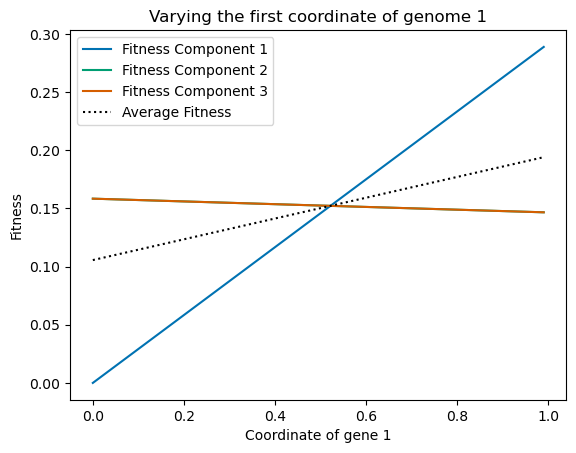

In [226]:
#visualisation for multilinearity test
for i in range(fit_var.shape[1]):
    plot.plot(np.array(range(len(fit_var))) / 100, fit_var[:, i], label=f'Fitness Component {i + 1}')

# Plot average fitness as a dotted line
plot.plot(np.array(range(len(fit_var))) / 100, avg_fit_var, color='k', linestyle='dotted', label='Average Fitness')

plot.xlabel('Coordinate of gene 1')
plot.ylabel('Fitness')
plot.title('Varying the first coordinate of genome 1')
plot.legend()
plot.show() #all fitness components should change linearly

In [229]:
# tbd: varying two coords
num_points = 100 
x1_values = np.linspace(0, 1, num_points)
x2_values = np.linspace(0, 1, num_points)
#meshgrid from x1 and x2 values
x1, x2 = np.meshgrid(x1_values, x2_values)
x3 = 
grid_coords = np.column_stack([x1.flatten(), x2.flatten(), np.full_like(x1.flatten(), x3)])


SyntaxError: invalid syntax (3633026800.py, line 7)

## The simulation

In [142]:
rd.seed(my_seed) # set random seed

# CONSTRUCT FITNESS LANDSCAPES 
fm_i = create_fitness_matrix_i()
fm_g = create_fitness_matrix_g()
# Construct epistasis matrices
em_i = create_epistasis_matrix_i()
em_g = create_epistasis_matrix_i()


# INIITIALIZE
genomes = initialize_genomes()
t = 0
# RUN SIMULATIONS
while t < t_end :
    rates = update_rates()
    propensity = sum(rates)
    tau = np.random.exponential(scale=1 / propensity) # waiting time for next reaction
    t = t + tau
    event = choose_event(rates)
    execute_reaction(event)


NameError: name 'initialize_genomes' is not defined

## Results